In [1]:
# %% [Cell 0] Imports & paths
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

# ---- locate files ----
DAY_READY_CANDS = [
    Path("../outputs/day_inperson_ready.csv"),
]
IND_CANDS = [
    Path("../data/dcpc_2024_indlevel_public.csv"),
]
DAYRAW_CANDS = [
    Path("../data/dcpc_2024_daylevel_public.csv"),
]
TRAN_CANDS = [
    Path("../data/dcpc_2024_tranlevel_public.csv"),
]

def pick_path(cands):
    for p in cands:
        if p.exists():
            return p
    raise FileNotFoundError("File not found in candidates: " + ", ".join(map(str, cands)))

DAY_READY_PATH = pick_path(DAY_READY_CANDS)
IND_PATH       = pick_path(IND_CANDS)
DAYRAW_PATH    = pick_path(DAYRAW_CANDS)
TRAN_PATH      = pick_path(TRAN_CANDS)

print("DAY_READY:", DAY_READY_PATH)
print("IND      :", IND_PATH)
print("DAY RAW  :", DAYRAW_PATH)
print("TRAN RAW :", TRAN_PATH)


DAY_READY: ..\outputs\day_inperson_ready.csv
IND      : ..\data\dcpc_2024_indlevel_public.csv
DAY RAW  : ..\data\dcpc_2024_daylevel_public.csv
TRAN RAW : ..\data\dcpc_2024_tranlevel_public.csv


In [2]:
# %% [Cell 1] Load day_ready + ind/day_raw, harmonize keys
day_ip = pd.read_csv(DAY_READY_PATH, low_memory=False)
ind_raw = pd.read_csv(IND_PATH, low_memory=False)
day_raw = pd.read_csv(DAYRAW_PATH, low_memory=False)

# harmonize day_ip
if "date" in day_ip.columns and "_date" not in day_ip.columns:
    day_ip.rename(columns={"date":"_date"}, inplace=True)
day_ip["_date"] = pd.to_datetime(day_ip["_date"], errors="coerce")
day_ip["_id"]   = pd.to_numeric(day_ip["_id"], errors="coerce")

# harmonize ind_raw id
id_ind = next((c for c in ["_id","id","person_id","PID"] if c in ind_raw.columns), None)
if id_ind is None:
    raise ValueError("ind-level 没有 id 列")
ind_raw.rename(columns={id_ind:"_id"}, inplace=True)
ind_raw["_id"] = pd.to_numeric(ind_raw["_id"], errors="coerce")

# harmonize day_raw id/date
id_day = next((c for c in ["_id","id","person_id","PID"] if c in day_raw.columns), None)
date_day = next((c for c in ["_date","date","diary_date"] if c in day_raw.columns), None)
if id_day is None or date_day is None:
    raise ValueError("day-level raw 没有 id 或 date 列")
day_raw.rename(columns={id_day:"_id", date_day:"_date"}, inplace=True)
day_raw["_id"]   = pd.to_numeric(day_raw["_id"], errors="coerce")
day_raw["_date"] = pd.to_datetime(day_raw["_date"], errors="coerce")

print("Loaded day_ip:", day_ip.shape)


Loaded day_ip: (7773, 31)


In [3]:
# %% [Cell 2] Ensure day_max_txn exists (rebuild from TRAN STRICT in-person if needed)
if "day_max_txn" not in day_ip.columns:
    print("No day_max_txn in day_ip. Rebuilding from TRAN (STRICT + in-person)...")
    tran = pd.read_csv(TRAN_PATH, low_memory=False)

    # harmonize id/date/amount
    id_tr = next((c for c in ["_id","id","person_id","PID"] if c in tran.columns), None)
    date_tr = next((c for c in ["_date","date"] if c in tran.columns), None)
    amt_tr = next((c for c in ["_amount","amnt","amount"] if c in tran.columns), None)
    if id_tr is None or date_tr is None or amt_tr is None:
        raise ValueError("TRAN 缺失 id/date/amount，无法重建 day_max_txn")
    tran.rename(columns={id_tr:"_id", date_tr:"_date", amt_tr:"_amount"}, inplace=True)
    tran["_id"] = pd.to_numeric(tran["_id"], errors="coerce")
    tran["_date"] = pd.to_datetime(tran["_date"], errors="coerce")
    tran["_amount"] = pd.to_numeric(tran["_amount"], errors="coerce")

    # keep real payments
    is_payment = (tran.get("payment", 1) == 1) & (tran.get("nonpaymenttran").isna())
    tran = tran[is_payment].copy()

    # keep in-person
    tran["_inperson"] = pd.to_numeric(tran.get("in_person"), errors="coerce")
    tran = tran[tran["_inperson"] == 1].copy()

    # STRICT PI keep
    tran["pi"] = pd.to_numeric(tran.get("pi"), errors="coerce")
    STRICT_LOW  = {3,4,6,7}
    STRICT_HIGH = {1,2,8}
    STRICT_KEEP = STRICT_LOW | STRICT_HIGH
    tran = tran[tran["pi"].isin(STRICT_KEEP)].copy()

    gmax = tran.groupby(["_id","_date"])["_amount"].max().rename("day_max_txn")
    day_ip = day_ip.merge(gmax, on=["_id","_date"], how="left")

print(day_ip["day_max_txn"].describe())


No day_max_txn in day_ip. Rebuilding from TRAN (STRICT + in-person)...
count     7552.000000
mean       104.928942
std        537.668352
min          0.000000
25%         16.865000
50%         36.550000
75%         78.480000
max      30050.000000
Name: day_max_txn, dtype: float64


In [4]:
# %% [Cell 3] Merge rich ind features + a few day-state features
# --- ind features by keywords ---
ind_keywords = ["income","inc_","educ","school","age","employ","work",
                "hhsize","household","marital","married"]
ind_cols = [c for c in ind_raw.columns if any(k in c.lower() for k in ind_keywords)]
ind_cols = [c for c in ind_cols if ind_raw[c].nunique(dropna=True) < 50]

ind_small = ind_raw[["_id"] + ind_cols].copy()
day_ip = day_ip.merge(ind_small, on="_id", how="left")

# --- day-state features by keywords ---
day_keywords = ["bill","pay","income","inc_","rent","mortgage","salary","wage"]
day_state_cols = [c for c in day_raw.columns if any(k in c.lower() for k in day_keywords)]
day_state_cols = [c for c in day_state_cols if day_raw[c].nunique(dropna=True) < 50]

day_small = day_raw[["_id","_date"] + day_state_cols].copy()
day_ip = day_ip.merge(day_small, on=["_id","_date"], how="left")

print("Merged rich columns:",
      len(ind_cols), "ind +", len(day_state_cols), "day-state")


Merged rich columns: 34 ind + 18 day-state


In [5]:
# %% [Cell 4] Apply price cap (cap=150 or 200) + build rich X with sparsity filtering
CAP = 150  # 改成 200 做敏感性
day_cap = day_ip[day_ip["day_max_txn"].notna() & (day_ip["day_max_txn"] <= CAP)].copy()
print(f"CAP={CAP} kept {len(day_cap)}/{len(day_ip)} days ({len(day_cap)/len(day_ip):.1%})")

# candidate rich X
X_cols_rich = (["_weekday"]
               + [c for c in day_cap.columns if str(c).startswith("mshare_")]
               + ind_cols + day_state_cols)

# keep only existing cols
X_cols_rich = [c for c in X_cols_rich if c in day_cap.columns]

# filter sparse/constant cols
MIN_NNZ = 0.80
nnz_rate = 1 - day_cap[X_cols_rich].isna().mean()
nuniq = day_cap[X_cols_rich].nunique(dropna=True)

X_keep = [c for c in X_cols_rich if nnz_rate[c] >= MIN_NNZ and nuniq[c] > 1]
X_cols_rich = list(dict.fromkeys(X_keep))

print("Filtered rich X dim =", len(X_cols_rich))
print(X_cols_rich)

# final analysis sample
T_col = "T_share_low_trim"   # 和 03 一致
Y_col = "Y_log_amt"          # log(1+day_total_amount)
sub = day_cap.dropna(subset=[T_col, Y_col] + X_cols_rich).copy()

print("Rows used:", len(sub), " persons:", sub["_id"].nunique())


CAP=150 kept 6710/7773 days (86.3%)
Filtered rich X dim = 44
['_weekday', 'mshare_1', 'mshare_2', 'mshare_3', 'mshare_4', 'mshare_5', 'mshare_6', 'mshare_7', 'mshare_8', 'mshare_9', 'mshare_10', 'mshare_12', 'mshare_13', 'mshare_14', 'mshare_15', 'mshare_16', 'mshare_17', 'mshare_18', 'mshare_19', 'mshare_20', 'mshare_21', 'highest_education', 'hhincome', 'marital_status', 'inc_doyouget_employment', 'inc_doyouget_empretire', 'inc_doyouget_selfemployment', 'inc_doyouget_socsec', 'inc_doyouget_interest', 'inc_doyouget_rental', 'inc_doyouget_govtasst', 'inc_doyouget_alimony', 'inc_doyouget_childsupport', 'inc_doyouget_otherretire', 'work_employed', 'work_onleave', 'work_temp_unemployed', 'work_looking', 'work_retired', 'work_disabled', 'work_other', 'carry_paypal', 'numberofpayments', 'anypayments']
Rows used: 5720  persons: 3646


In [6]:
# %% [Cell 5] Helpers: OHE, cross-fitted residuals (partialling-out)
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False, dtype=np.float32)

def crossfit_residuals(X_df, T, Y, sample_weight=None, n_splits=5, seed=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    n = len(Y)
    y_res = np.zeros(n)
    t_res = np.zeros(n)
    W = np.ones(n) if sample_weight is None else np.asarray(sample_weight)

    X_cat = ["_weekday"]
    X_mer = [c for c in X_df.columns if str(c).startswith("mshare_")]
    X_other = [c for c in X_df.columns if c not in X_cat + X_mer]

    pre = ColumnTransformer(
        transformers=[
            ("cat", make_ohe(), X_cat),
            ("mer", "passthrough", X_mer),
            ("oth", "passthrough", X_other),
        ],
        remainder="drop"
    )

    for tr, te in kf.split(X_df):
        Xt, Xv = X_df.iloc[tr], X_df.iloc[te]
        Tt, Tv = T[tr], T[te]
        Yt, Yv = Y[tr], Y[te]
        Wt = W[tr]

        Zt = pre.fit_transform(Xt)
        Zv = pre.transform(Xv)

        fY = RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=seed)\
             .fit(Zt, Yt, sample_weight=Wt)
        fT = RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=seed)\
             .fit(Zt, Tt, sample_weight=Wt)

        y_res[te] = Yv - fY.predict(Zv)
        t_res[te] = Tv - fT.predict(Zv)

    return y_res, t_res, pre


In [7]:
# %% [Cell 6] Global theta via DR-loss (scalar ATE check)
X_df = sub[X_cols_rich]
T = sub[T_col].values
Y = sub[Y_col].values

# optional weights if w_day exists
sw = sub["w_day"].values if "w_day" in sub.columns else None

y_res, t_res, pre_X = crossfit_residuals(X_df, T, Y, sample_weight=sw, n_splits=5, seed=42)

w = np.ones_like(Y) if sw is None else sw / np.mean(sw)

theta = np.average(t_res * y_res, weights=w) / np.average(t_res**2, weights=w)
dr_loss_scalar = np.average((y_res - t_res * theta)**2, weights=w)

pct10 = (np.exp(0.10 * theta) - 1) * 100
print(f"[DR-loss rich] global theta={theta:.4f}  → per +10pp ≈ {pct10:.1f}%")
print("DR-loss (scalar theta) =", dr_loss_scalar)
print("Rows used:", len(sub), " persons:", sub["_id"].nunique())


[DR-loss rich] global theta=0.5416  → per +10pp ≈ 5.6%
DR-loss (scalar theta) = 0.7424479268569733
Rows used: 5720  persons: 3646


In [8]:
# %% [Cell 7] CATE via DR-loss / R-learner style ridge (FIXED DIM BUG)
# Z = encoded rich X
Z = pre_X.transform(X_df)   # IMPORTANT: use SAME pre_X from residual step
Z = np.asarray(Z)

# Modulated design: t_res * Z
Z_mod = Z * t_res[:, None]

alpha = 1.0   # ridge strength, 可调 {0.5,1,2}
ridge = Ridge(alpha=alpha, fit_intercept=True)
ridge.fit(Z_mod, y_res, sample_weight=w)

# tau_hat(x) = intercept + Z @ coef  (NO MANUAL SLICING!)
tau_hat = ridge.intercept_ + Z @ ridge.coef_
tau_hat = tau_hat.ravel()

sub["tau_hat"] = tau_hat

dr_loss_cate = np.average((y_res - t_res * tau_hat)**2, weights=w)
print(f"[CATE rich] DR-loss =", dr_loss_cate)
print(sub["tau_hat"].describe())


[CATE rich] DR-loss = 0.7284604797261591
count    5720.000000
mean        0.579273
std         0.331274
min        -1.226654
25%         0.378405
50%         0.594504
75%         0.796041
max         1.920084
Name: tau_hat, dtype: float64


In [9]:
# %% [Cell 8] Simple heterogeneity summaries (weekday / avg-ticket terciles)
# weekday heterogeneity
tau_wd = sub.groupby("_weekday")["tau_hat"].mean()
print("Mean tau by weekday:")
print(tau_wd)

# avg-ticket heterogeneity
if "n_tx" in sub.columns and "day_total_amount" in sub.columns:
    sub["avg_ticket"] = sub["day_total_amount"] / sub["n_tx"].replace(0, np.nan)
else:
    # fallback if avg_ticket not precomputed
    sub["avg_ticket"] = np.expm1(sub[Y_col]) / sub["n_tx"].replace(0, np.nan)

sub["q"] = pd.qcut(sub["avg_ticket"], 3, labels=["L","M","H"])
tau_q = sub.groupby("q")["tau_hat"].mean()
print("\nMean tau by avg_ticket tercile:")
print(tau_q)


Mean tau by weekday:
_weekday
0    0.531690
1    0.575196
2    0.568915
3    0.519371
4    0.600360
5    0.607401
6    0.673362
Name: tau_hat, dtype: float64

Mean tau by avg_ticket tercile:
q
L    0.523980
M    0.576910
H    0.636928
Name: tau_hat, dtype: float64


C:\Users\Kaiyan Zhang\AppData\Local\Temp\ipykernel_35808\442990322.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tau_q = sub.groupby("q")["tau_hat"].mean()


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 选出有 tau_hat 的那张表 ----
if "sub_cate" in globals():
    df_cate = sub_cate.copy()
elif "sub" in globals():
    df_cate = sub.copy()
else:
    raise NameError("找不到 sub_cate 或 sub，请确认 DR-loss + CATE 那一格的变量名。")

# 确保这些列都在：tau_hat, _weekday, day_total_amount, n_tx
needed = ["tau_hat", "_weekday", "day_total_amount", "n_tx"]
missing = [c for c in needed if c not in df_cate.columns]
if missing:
    raise ValueError(f"df_cate 缺少列: {missing}")

# 丢掉明显无效的
df_cate = df_cate.dropna(subset=["tau_hat", "_weekday", "day_total_amount", "n_tx"]).copy()
df_cate = df_cate[df_cate["n_tx"] > 0].copy()

# 构造 avg_ticket
df_cate["avg_ticket"] = df_cate["day_total_amount"] / df_cate["n_tx"]

print("CATE sample for plotting:")
print("  rows   =", len(df_cate))
print("  persons=", df_cate["_id"].nunique() if "_id" in df_cate.columns else "n/a")
print(df_cate[["tau_hat","_weekday","avg_ticket"]].head())


CATE sample for plotting:
  rows   = 5720
  persons= 3646
    tau_hat  _weekday  avg_ticket
0  1.335794         6       50.00
1  1.124052         0       40.24
2  0.984889         6       18.00
3  0.129806         0       23.20
4  0.575560         1       43.53


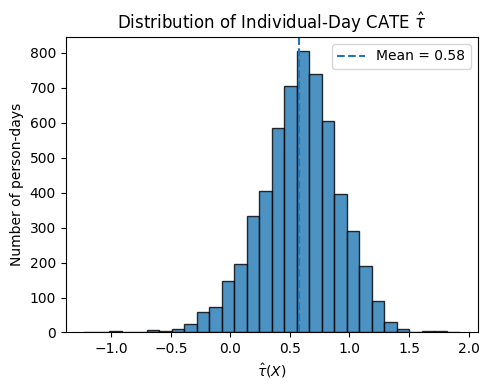

In [11]:
# === Figure 1: Distribution of tau_hat (CATE) ===
fig, ax = plt.subplots(figsize=(5,4))

ax.hist(df_cate["tau_hat"], bins=30, edgecolor="black", alpha=0.8)
ax.axvline(df_cate["tau_hat"].mean(), linestyle="--", linewidth=1.5, label=f"Mean = {df_cate['tau_hat'].mean():.2f}")

ax.set_title("Distribution of Individual-Day CATE $\\hat{\\tau}$")
ax.set_xlabel("$\\hat{\\tau}(X)$")
ax.set_ylabel("Number of person-days")
ax.legend()

plt.tight_layout()
# 如需保存：
# fig.savefig("../figures/04_tau_hist.png", dpi=300, bbox_inches="tight")
plt.show()


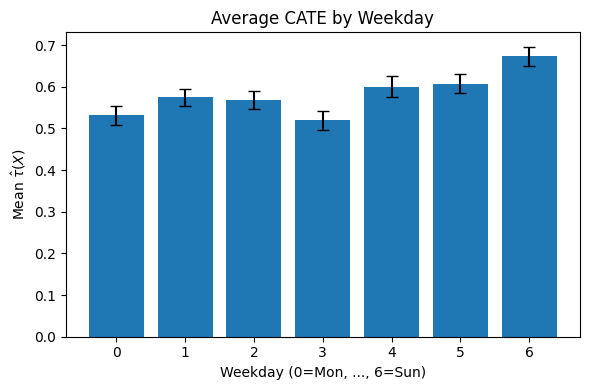

Mean tau by weekday:
_weekday
0    0.531690
1    0.575196
2    0.568915
3    0.519371
4    0.600360
5    0.607401
6    0.673362
Name: tau_hat, dtype: float64


In [12]:
# === Figure 2: Mean CATE by weekday (with error bars) ===
wd = df_cate.groupby("_weekday")["tau_hat"]
wd_mean = wd.mean()
wd_se   = wd.std() / np.sqrt(wd.count())
wd_ci95 = 1.96 * wd_se

fig, ax = plt.subplots(figsize=(6,4))

x = wd_mean.index.values
ax.bar(x, wd_mean.values, yerr=wd_ci95.values, capsize=4)
ax.set_xticks(x)
ax.set_xticklabels(x)  # 0=Mon ... 6=Sun，如果你想中文可以自己改 label

ax.set_title("Average CATE by Weekday")
ax.set_xlabel("Weekday (0=Mon, ..., 6=Sun)")
ax.set_ylabel("Mean $\\hat{\\tau}(X)$")

plt.tight_layout()
# fig.savefig("../figures/04_tau_by_weekday.png", dpi=300, bbox_inches="tight")
plt.show()

print("Mean tau by weekday:")
print(wd_mean)


C:\Users\Kaiyan Zhang\AppData\Local\Temp\ipykernel_35808\3973421230.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  qg = df_cate.groupby("avg_ticket_q")["tau_hat"]


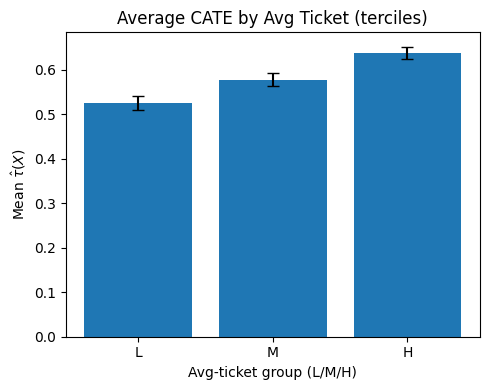

Mean tau by avg_ticket tercile:
avg_ticket_q
L    0.523980
M    0.576910
H    0.636928
Name: tau_hat, dtype: float64


In [13]:
# === Figure 3: Mean CATE by avg-ticket tercile ===

# 先做三分位 bucket
df_cate = df_cate.copy()
df_cate["avg_ticket_q"] = pd.qcut(df_cate["avg_ticket"], q=3, labels=["L","M","H"])

qg = df_cate.groupby("avg_ticket_q")["tau_hat"]
q_mean = qg.mean()
q_se   = qg.std() / np.sqrt(qg.count())
q_ci95 = 1.96 * q_se

fig, ax = plt.subplots(figsize=(5,4))

x = np.arange(len(q_mean))
ax.bar(x, q_mean.values, yerr=q_ci95.values, capsize=4)
ax.set_xticks(x)
ax.set_xticklabels(q_mean.index)

ax.set_title("Average CATE by Avg Ticket (terciles)")
ax.set_xlabel("Avg-ticket group (L/M/H)")
ax.set_ylabel("Mean $\\hat{\\tau}(X)$")

plt.tight_layout()
# fig.savefig("../figures/04_tau_by_avg_ticket.png", dpi=300, bbox_inches="tight")
plt.show()

print("Mean tau by avg_ticket tercile:")
print(q_mean)


In [14]:
# Z = encoded rich X
Z = pre_X.transform(X_df)
Z = np.asarray(Z)

Z_mod = Z * t_res[:, None]

alpha = 1.0
ridge = Ridge(alpha=alpha, fit_intercept=True)
ridge.fit(Z_mod, y_res, sample_weight=w)

tau_hat = ridge.intercept_ + Z @ ridge.coef_
tau_hat = tau_hat.ravel()

sub["tau_hat"] = tau_hat


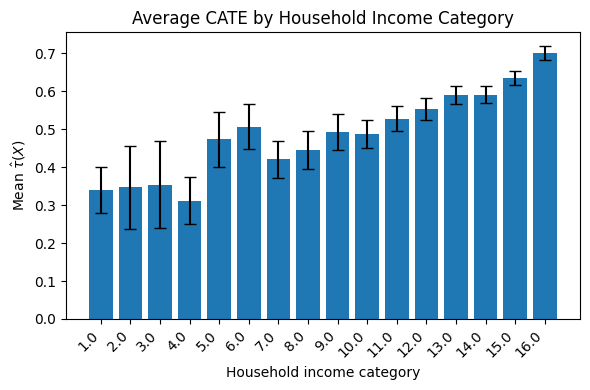

Mean tau by income category:
hhincome
1.0     0.340256
2.0     0.346617
3.0     0.353960
4.0     0.310971
5.0     0.473323
6.0     0.505749
7.0     0.420114
8.0     0.445851
9.0     0.492402
10.0    0.487048
11.0    0.527815
12.0    0.553068
13.0    0.590492
14.0    0.590631
15.0    0.635241
16.0    0.701048
Name: tau_hat, dtype: float64


In [15]:
# Example: assuming column name is "hhincome_cat"
df_cate = df_cate.copy()
df_cate = df_cate[df_cate["hhincome"].notna()]

g = df_cate.groupby("hhincome")["tau_hat"]
inc_mean = g.mean()
inc_se   = g.std() / np.sqrt(g.count())
inc_ci95 = 1.96 * inc_se

fig, ax = plt.subplots(figsize=(6,4))

x = np.arange(len(inc_mean))
ax.bar(x, inc_mean.values, yerr=inc_ci95.values, capsize=4)
ax.set_xticks(x)
ax.set_xticklabels(inc_mean.index, rotation=45, ha="right")

ax.set_title("Average CATE by Household Income Category")
ax.set_xlabel("Household income category")
ax.set_ylabel("Mean $\\hat{\\tau}(X)$")

plt.tight_layout()
plt.show()

print("Mean tau by income category:")
print(inc_mean)


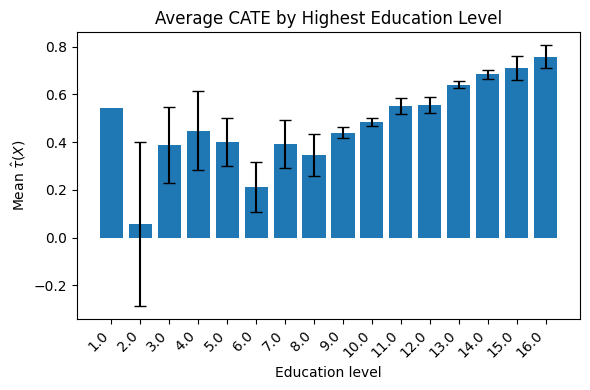

Mean tau by education level:
highest_education
1.0     0.543693
2.0     0.058347
3.0     0.387132
4.0     0.448495
5.0     0.400122
6.0     0.212622
7.0     0.394171
8.0     0.345737
9.0     0.439721
10.0    0.485436
11.0    0.550738
12.0    0.556771
13.0    0.641633
14.0    0.683941
15.0    0.711836
16.0    0.757921
Name: tau_hat, dtype: float64


In [16]:
df_cate = df_cate.copy()
df_cate = df_cate[df_cate["highest_education"].notna()]

g = df_cate.groupby("highest_education")["tau_hat"]
edu_mean = g.mean()
edu_se   = g.std() / np.sqrt(g.count())
edu_ci95 = 1.96 * edu_se

fig, ax = plt.subplots(figsize=(6,4))

x = np.arange(len(edu_mean))
ax.bar(x, edu_mean.values, yerr=edu_ci95.values, capsize=4)
ax.set_xticks(x)
ax.set_xticklabels(edu_mean.index, rotation=45, ha="right")

ax.set_title("Average CATE by Highest Education Level")
ax.set_xlabel("Education level")
ax.set_ylabel("Mean $\\hat{\\tau}(X)$")

plt.tight_layout()
plt.show()

print("Mean tau by education level:")
print(edu_mean)


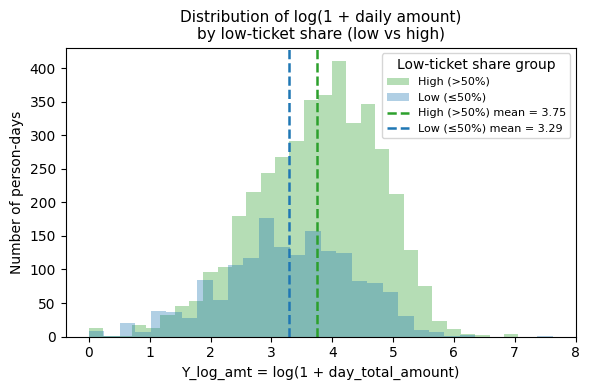

Group means of Y_log_amt (low vs high T_share_low):
T_bin
High (>50%)    3.753140
Low (≤50%)     3.287307
Name: Y_log_amt, dtype: float64


In [17]:
df_cate = df_cate.copy()

# binary split: low vs high low-ticket share
df_cate["T_bin"] = np.where(df_cate[T_col] <= 0.5, "Low (≤50%)", "High (>50%)")

fig, ax = plt.subplots(figsize=(6, 4))

bin_colors = {
    "Low (≤50%)":  "#1f77b4",
    "High (>50%)": "#2ca02c",
}

for label, group in df_cate.groupby("T_bin"):
    if group.empty:
        continue
    ax.hist(
        group[Y_col],
        bins=30,
        alpha=0.35,
        label=str(label),
        color=bin_colors.get(str(label), None),
        density=False,
    )

bin_means = df_cate.groupby("T_bin")[Y_col].mean()
for label, mean_val in bin_means.items():
    color = bin_colors.get(str(label), "black")
    ax.axvline(
        mean_val,
        linestyle="--",
        linewidth=1.8,
        color=color,
        label=f"{label} mean = {mean_val:.2f}",
    )

ax.set_title(
    "Distribution of log(1 + daily amount)\n"
    "by low-ticket share (low vs high)",
    fontsize=11,
)
ax.set_xlabel("Y_log_amt = log(1 + day_total_amount)", fontsize=10)
ax.set_ylabel("Number of person-days", fontsize=10)

handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title="Low-ticket share group", fontsize=8)

plt.tight_layout()
plt.show()

print("Group means of Y_log_amt (low vs high T_share_low):")
print(bin_means)
